In [5]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HUGGINGFACE_API_KEY')

In [66]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

In [11]:
model = ChatGroq(model_name="moonshotai/kimi-k2-instruct-0905")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [55]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print(f"this is my current message: {messages}")
    response = model.invoke(messages)
    return {"messages": [response]}

### this code is for testing

In [56]:
state = {"messages": ["Hi"]}
call_model(state)["messages"][0].content

this is my current message: ['Hi']


'Hi there! What can I help you with today?'

In [57]:
workflow = StateGraph(MessagesState)

In [58]:
workflow.add_node("mybot", call_model)


In [59]:
workflow.add_edge(START, "mybot")

In [60]:
workflow.add_edge("mybot", END)

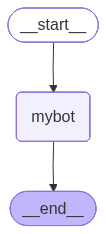

In [61]:
workflow.compile()

In [62]:
app = workflow.compile()

In [63]:
input = {"messages": ["Who is the president of the United States?"]}

In [64]:
app.invoke(input)

this is my current message: [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='6feb6bab-78ae-4fd8-a83f-2c123a1fdebb')]


{'messages': [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='6feb6bab-78ae-4fd8-a83f-2c123a1fdebb'),
  AIMessage(content='As of my last knowledge update in July 2024, the President of the United States is **Joe Biden**. He has been serving as the 46th president since January 20, 2021. The next presidential election is scheduled for November 2024, with the winner taking office in January 2025. For developments beyond July 2024, I recommend checking the latest, reliable news sources.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 35, 'total_tokens': 119, 'completion_time': 0.233317327, 'completion_tokens_details': None, 'prompt_time': 0.010232448, 'prompt_tokens_details': None, 'queue_time': 0.285773589, 'total_time': 0.243549775}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'st

### Custom tool

In [67]:
@tool
def search(query: str):
    """this is my custom tool for searching a weather in a city"""
    if "delhi" in query.lower():
        return "the weather in delhi is 25 degrees celsius"
    return "i am not sure about the weather in that city"

In [69]:
search.invoke("what is the weather in bangalore?")

'i am not sure about the weather in that city'